In [1]:
import sys
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf
import tensorflow.keras
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tensorflow.keras.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # ignore tensorflow warnings

TensorFlow version: 2.1.0
Keras version: 2.2.4-tf
Python 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Pandas 1.1.1
Scikit-Learn 0.23.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
train = pd.read_json('train.json', lines=True)
test = pd.read_json('test.json', lines=True)
public = test.query('seq_length == 107').copy()
private = test.query('seq_length == 130').copy()
print(train.shape)
print(public.shape)
print(private.shape)

(2400, 19)
(629, 7)
(3005, 7)


In [3]:
def process_seq(data, seq_length):
    # processes the 3 sequences and the target
    seq = data.loc[:, 'sequence'].str.slice(0, seq_length).values
    struct = data.loc[:, 'structure'].str.slice(0, seq_length).values
    loop = data.loc[:, 'predicted_loop_type'].str.slice(0, seq_length).values
    
    n = data.shape[0]

    new_seq = []
    new_struct = []
    new_loop = []

    for i in range(n):
        # sequence processing
        seq_dic = {'A': 0, 'C': 1, 'G': 2, 'U': 3} 
        n_seq = [seq_dic[l] for l in seq[i]]
        new_seq.append(n_seq)

        # structure processing
        struct_dic = {'(': 4, '.': 5, ')': 6}
        n_struct = [struct_dic[l] for l in struct[i]]
        new_struct.append(n_struct)

        # predicted_loop_type processing
        loop_dic = {'S':7, 'M':8, 'I':9, 'B':10, 'H':11, 'E':12, 'X':13}
        n_loop = [loop_dic[l] for l in loop[i]]
        new_loop.append(n_loop)
        
    new_seq = np.array(new_seq)
    new_struct = np.array(new_struct)
    new_loop = np.array(new_loop)
        
    new_seq = new_seq.reshape(new_seq.shape[0], new_seq.shape[1], 1) 
    new_struct = new_struct.reshape(new_struct.shape[0], new_struct.shape[1], 1)
    new_loop = new_loop.reshape(new_loop.shape[0], new_loop.shape[1], 1)
    
    return np.concatenate([new_seq, new_struct, new_loop], axis=2)

def process_target(data, seq_scored):
    n = data.shape[0]
    y_train = data.loc[:, ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']]
    new_target = np.zeros((n, 5, seq_scored))
    
    for i in range(n):
        new_target[i, :, :] = np.concatenate(y_train.values[i]).reshape(5, seq_scored)
    # swap the 2 last axes to match sequence shape
    new_target = np.swapaxes(new_target, 1, 2)
    return new_target

In [4]:
features = process_seq(train, seq_length=107)
features_public = process_seq(public, seq_length=107)
features_private = process_seq(private, seq_length=130)

target = process_target(train, seq_scored=68)

def get_dummies(features):
    seq1 = tensorflow.keras.utils.to_categorical(features[:, :, 0], 4)
    seq2 = tensorflow.keras.utils.to_categorical(features[:, :, 1]-4, 3)
    seq3 = tensorflow.keras.utils.to_categorical(features[:, :, 2]-7, 7)
    return np.concatenate([seq1, seq2, seq3], axis=-1)
    
features = get_dummies(features)
features_public = get_dummies(features_public)
features_private = get_dummies(features_private)
print(features.shape)
print(features_public.shape)
print(features_private.shape)
print(target.shape)
# features of the first 4 bases of the first sequence
print(features[0, :4, :])

(2400, 107, 14)
(629, 107, 14)
(3005, 130, 14)
(2400, 68, 5)
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [5]:
def get_bpps(ids):
    # retrieve bpps matrices
    bpps = []
    for id in tqdm(ids):
        bpps.append(np.load(f"bpps/{id}.npy"),)
    return np.array(bpps)


X_bpps = get_bpps(train.id.values)
X_bpps_public = get_bpps(public.id.values)
X_bpps_private = get_bpps(private.id.values)
print(X_bpps.shape)
print(X_bpps_public.shape)
print(X_bpps_private.shape)

100%|████████████████████████████████████████████████████████████████████████████| 3005/3005 [00:00<00:00, 3263.41it/s]


(2400, 107, 107)
(629, 107, 107)
(3005, 130, 130)


In [6]:
def min_max_norm(m):
    # min max scaling for non negatives values
    maxi = np.amax(m) + 1e-8  # avoid dividing by 0
    return m / maxi


def get_nonzeros(X_bpps):
    # return non 0 proportion of each row of the bpps files
    X_bpps_nonzeros_prop = []
    n = X_bpps.shape[0]
    seq_length = X_bpps.shape[1]
    for k in range(n):
        X_bpps_nonzeros_prop.append(1 - ((X_bpps[k] == 0).sum(axis=1) / seq_length))
    X_bpps_nonzeros_prop = np.array(X_bpps_nonzeros_prop)
    return X_bpps_nonzeros_prop


def get_dist(sequences, structures, seq_length):
    # return new sequence corresponding to the associated paires of sequences
    # return distance matrix according to the distance between paired bases
    dist = np.zeros((structures.shape[0], seq_length, seq_length))
    idx = []
    pair_base = np.zeros((structures.shape[0], seq_length))
    for row, structure in tqdm(enumerate(structures)):
        for i, token in enumerate(structure):
            if token == "(":
                idx.append(i)
            elif token == ")":
                j = idx.pop()  # index of the corresponding '(' 
                dist[row, i, j] = i-j
                dist[row, j, i] = i-j
                pair_base[row, j] = sequences[row, i] + 15
                pair_base[row, i] = sequences[row, j] + 15
    pair_base[np.where(pair_base == 0)] = 14
    return pair_base.reshape(structures.shape[0], seq_length, 1), dist


def get_features(sequences, data, seq_length):
    # return the stats features from bpps files
    X_bpps = get_bpps(data.id.values)  # retrieve bpps matrices
    X_pair, X_dist = get_dist(sequences, data['structure'].str.slice(0, seq_length), seq_length)
    X_bpps_nonzeros_prop = get_nonzeros(X_bpps)

    train_bpps_stats = [min_max_norm(X_bpps.sum(axis=2)),  # mean of non zeros values for each base
                        min_max_norm(X_bpps.max(axis=2)),  # max value for each base
                        min_max_norm(X_bpps_nonzeros_prop),  # proportion of non zeros for each base
                        min_max_norm(X_dist.sum(axis=2))]  # distance of the base to its partner 
    X_stats = np.concatenate([stats[:,:,None] for stats in train_bpps_stats], axis=2)
    return X_pair, X_stats, X_bpps, X_dist

# bpps stats features
X_pair, X_stats, X_bpps, X_dist = get_features(features[:, :, 0], train, seq_length=107)
X_pair_public, X_stats_public, X_bpps_public, X_dist_public = get_features(features_public[:, :, 0], public, seq_length=107)
X_pair_private, X_stats_private, X_bpps_private, X_dist_private = get_features(features_private[:, :, 0], private, seq_length=130)

X_pair = tensorflow.keras.utils.to_categorical(X_pair-14, 5)
X_pair_public = tensorflow.keras.utils.to_categorical(X_pair_public-14, 5)
X_pair_private = tensorflow.keras.utils.to_categorical(X_pair_private-14, 5)

# concatenate sequences features and bpps stats features
X = np.concatenate([features, X_pair, X_stats], axis=2)
np.save('X.npy', X)
X_public = np.concatenate([features_public, X_pair_public, X_stats_public], axis=2)
np.save('X_public.npy', X_public)
X_private = np.concatenate([features_private, X_pair_private, X_stats_private], axis=2)
np.save('X_private.npy', X_private)
y = target
np.save('y.npy', y)

100%|████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:00<00:00, 3457.93it/s]
2400it [00:00, 7808.36it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 629/629 [00:00<00:00, 3447.90it/s]
629it [00:00, 7491.21it/s]
100%|████████████████████████████████████████████████████████████████████████████| 3005/3005 [00:00<00:00, 3258.06it/s]
3005it [00:00, 5584.41it/s]


In [7]:
# split data
# lets select validation indexes where SN_filter = 1. 
# Indeed private test sequences are based on that type of filter
np.random.seed(42)
idx_filter = np.where(train.SN_filter == 1)[0]
choice = np.random.choice(idx_filter, 256, replace=False)
idx_valid = np.ones(X.shape[0], dtype=np.bool)
idx_valid[choice] = False

X_train = X[idx_valid, :, :]
X_valid = X[~idx_valid, :, :]
y_train = y[idx_valid]
y_valid = y[~idx_valid]

# add importance to each observation
weights = np.array(np.log(train.signal_to_noise + 1.10)/2) 
train_weight = weights[idx_valid]

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)
print(X_public.shape)
print(X_private.shape)
print(X_train[0, :8, 19:])  # stats for the first 4 bases of the first sequence
print(train_weight.shape)

(2144, 107, 23)
(256, 107, 23)
(2144, 68, 5)
(256, 68, 5)
(629, 107, 23)
(3005, 130, 23)
[[0.19854398 0.02178589 0.31818181 0.        ]
 [0.18371376 0.03865303 0.22727272 0.        ]
 [0.06000291 0.02759063 0.05681818 0.        ]
 [0.01312232 0.00947074 0.04545454 0.        ]
 [0.01127996 0.00702879 0.03409091 0.        ]
 [0.12739688 0.0698996  0.06818182 0.24050633]
 [0.35076808 0.11479298 0.22727272 0.21518987]
 [0.54090509 0.35668104 0.15909091 0.17721519]]
(2144,)


In [8]:
def build_model(input_seq, input_stats, seq_length, seq_scored):
    input_seq = Input((seq_length, input_seq))
    input_stats = Input((seq_length, input_stats))
    
    # concat embedded sequences and bpps stats
    x = concatenate([input_seq, input_stats])
    x = Dense(512, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = Dropout(0.1)(x)
    x = Dense(512, activation='relu', kernel_initializer='glorot_uniform')(x)
    x = Dropout(0.1)(x)
    x = Dense(512, activation='relu', kernel_initializer='glorot_uniform')(x)

    # we need only the first seq_scored bases
    x = x[:, :seq_scored]
    
    output = Dense(5, activation=None)(x)
    model = Model(inputs=[input_seq, input_stats], outputs=output)
    
    opt = optimizers.Adam(lr=0.001)
    
    # we use the loss that is used for the evaluation according to the rules
    def mcrmse(y_true, y_pred):
        # Mean Columnwise Root Mean Squared Error
        colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
        res = tf.reduce_mean(tf.sqrt(colwise_mse), axis=1)
        return res

    model.compile(loss=mcrmse, optimizer=opt)
    
    return model

In [9]:
def train_model(model, X_train, X_valid, y_train, y_valid, train_weight, n_epoch=200, batch_size=128, verbose=1):
    checkpoint_filepath = 'MyCheckpoint'
    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                 monitor='val_loss',
                                 mode='min',
                                 save_weights_only=True,
                                 save_best_only=True)
    reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.3,
                                                             patience=15,
                                                             min_lr=9.001e-5,
                                                             verbose=1)
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              patience=20, 
                                                              mode='auto',
                                                              baseline=None,
                                                              restore_best_weights=True,
                                                              verbose=0)
    callback = [checkpoint, reduce_lr, early_stopping]
        
    
    X_train_seq = X_train[:, :, :19]
    X_train_stats = X_train[:, :, 19:]
        
    X_valid_seq = X_valid[:, :, :19]
    X_valid_stats = X_valid[:, :, 19:]
    validation_data = ([X_valid_seq, X_valid_stats], y_valid)
    
    history = model.fit([X_train_seq, X_train_stats], y_train, sample_weight=train_weight, validation_data=validation_data, 
                        epochs=n_epoch, batch_size=batch_size, verbose=verbose, callbacks=callback)
    return model, history

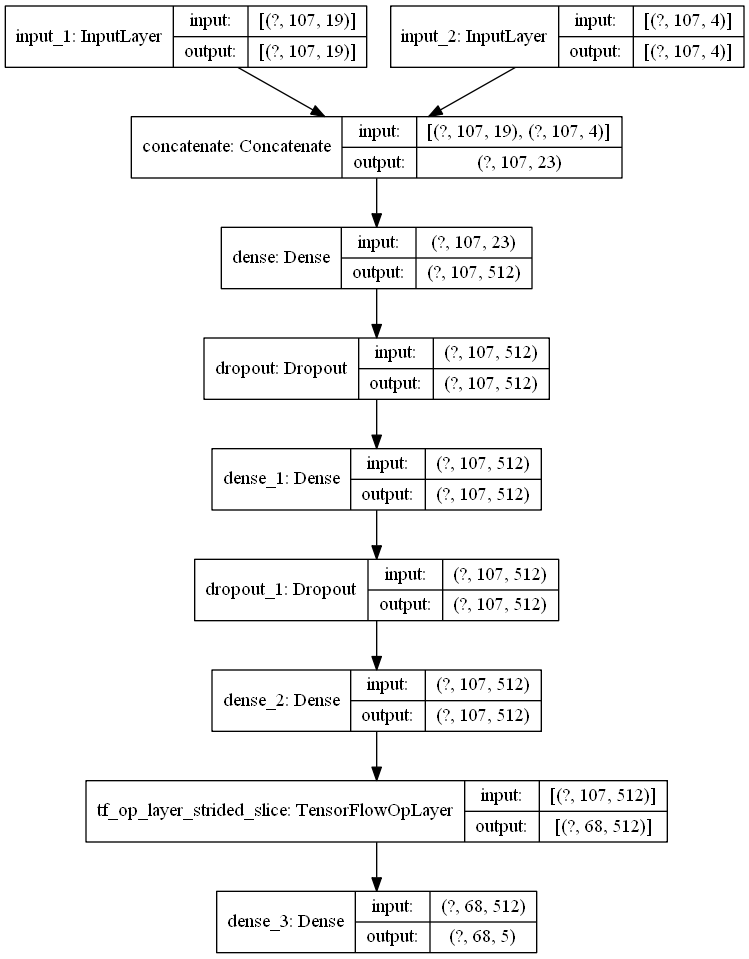

In [10]:
clear_session()
model = build_model(input_seq=19, input_stats=4, seq_length=107, seq_scored=68)
plot_model(model, to_file='model.png', show_shapes=True)

In [11]:
model, history = train_model(model, X_train, X_valid, y_train, y_valid, train_weight, n_epoch=250, batch_size=256, verbose=1)

Train on 2144 samples, validate on 256 samples
Epoch 1/250
2144/2144 [==============================] - 1s 626us/sample - loss: 0.3918 - val_loss: 0.4350
Epoch 2/250
2144/2144 [==============================] - 1s 244us/sample - loss: 0.3462 - val_loss: 0.4116
Epoch 3/250
2144/2144 [==============================] - 0s 229us/sample - loss: 0.3357 - val_loss: 0.4075
Epoch 4/250
2144/2144 [==============================] - 1s 241us/sample - loss: 0.3317 - val_loss: 0.4039
Epoch 5/250
2144/2144 [==============================] - 0s 229us/sample - loss: 0.3303 - val_loss: 0.4018
Epoch 6/250
2144/2144 [==============================] - 0s 131us/sample - loss: 0.3292 - val_loss: 0.4018
Epoch 7/250
2144/2144 [==============================] - 1s 269us/sample - loss: 0.3289 - val_loss: 0.4005
Epoch 8/250
2144/2144 [==============================] - 1s 245us/sample - loss: 0.3284 - val_loss: 0.4001
Epoch 9/250
2144/2144 [==============================] - 1s 256us/sample - loss: 0.3282 - val_los

2144/2144 [==============================] - 0s 129us/sample - loss: 0.3229 - val_loss: 0.3964
Epoch 75/250
2144/2144 [==============================] - 0s 129us/sample - loss: 0.3228 - val_loss: 0.3960
Epoch 76/250
2144/2144 [==============================] - 0s 129us/sample - loss: 0.3228 - val_loss: 0.3964
Epoch 77/250
2144/2144 [==============================] - 0s 129us/sample - loss: 0.3230 - val_loss: 0.3962
Epoch 78/250
2144/2144 [==============================] - 1s 237us/sample - loss: 0.3228 - val_loss: 0.3957
Epoch 79/250
2144/2144 [==============================] - 0s 130us/sample - loss: 0.3228 - val_loss: 0.3963
Epoch 80/250
2144/2144 [==============================] - 0s 130us/sample - loss: 0.3226 - val_loss: 0.3959
Epoch 81/250
2144/2144 [==============================] - 0s 130us/sample - loss: 0.3226 - val_loss: 0.3963
Epoch 82/250
2144/2144 [==============================] - 0s 129us/sample - loss: 0.3226 - val_loss: 0.3960
Epoch 83/250
2144/2144 [=================

256/256 [==============================] - 0s 336us/sample - loss: 0.3954
Loss valid: 0.3954497277736664


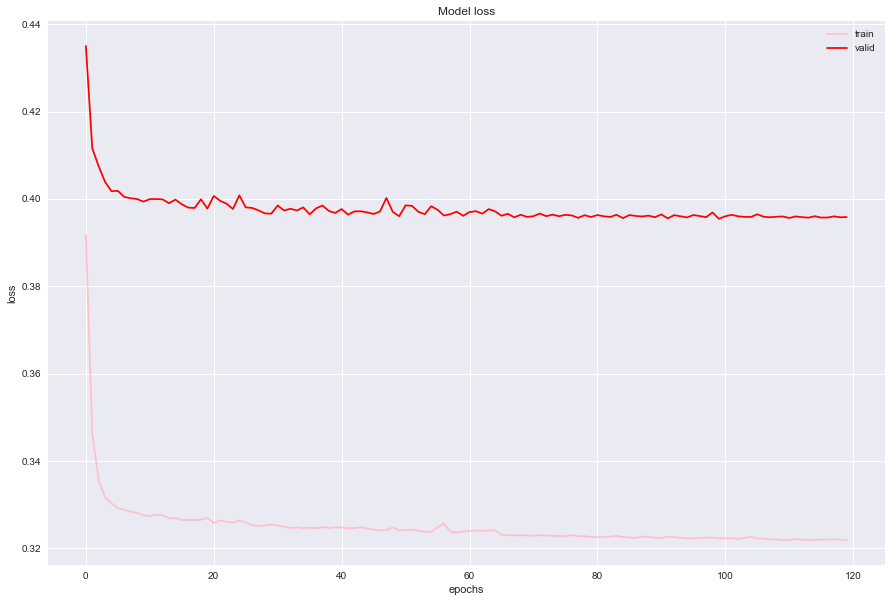

In [12]:
model.load_weights('MyCheckpoint')  # load best model
plot_model(model, to_file='model.png', show_shapes=True)
loss_valid = model.evaluate([X_valid[:, :, :19], X_valid[:, :, 19:]], y_valid) 
print('Loss valid: {}'.format(loss_valid))  

def plot_history(history):
    plt.figure(figsize=(15, 10))
    plt.plot(history.history['loss'], color='pink', label='train')
    plt.plot(history.history['val_loss'], color='red', label='valid')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
    
plot_history(history)

In [13]:
# for the submission we need the full length so we set seq_scored to seq_length
model_public = build_model(input_seq=19, input_stats=4, seq_length=107, seq_scored=107)
model_private = build_model(input_seq=19, input_stats=4, seq_length=130, seq_scored=130)

In [14]:
model_public.load_weights('MyCheckpoint')
pred_public = model_public.predict([X_public[:, :, :19], X_public[:, :, 19:]])
pred_public[pred_public < 0.0] = 0.0
pred_public[pred_public > 6.0] = 6.0

model_private.load_weights('MyCheckpoint')
pred_private = model_private.predict([X_private[:, :, :19], X_private[:, :, 19:]])
pred_private[pred_private < 0.0] = 0.0
pred_private[pred_private > 6.0] = 6.0

In [15]:
def build_submission(public, private, pred_public, pred_private):
    preds = []
    for df, pred in [(public, pred_public), (private, pred_private)]:
        for i, uid in enumerate(df.id):
            single_pred = pred[i]
            single_df = pd.DataFrame(single_pred, columns=['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C'])
            single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
            preds.append(single_df)
    return pd.concat(preds).reset_index(drop=True)

sub = build_submission(public, private, pred_public, pred_private)
cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C', 'id_seqpos']
cols = cols[-1:] + cols[:-1]
sub = sub[cols]
sub.to_csv('MySubmission.csv', index=False)  # ready for submission
sub

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.900296,1.183267,2.250781,1.132562,1.189841
1,id_00073f8be_1,0.951457,1.260056,2.338922,1.200834,1.266439
2,id_00073f8be_2,0.575763,0.449040,0.569300,0.565244,0.634184
3,id_00073f8be_3,0.625775,0.483063,0.615021,0.630497,0.676216
4,id_00073f8be_4,0.626447,0.486095,0.616586,0.633088,0.678100
...,...,...,...,...,...,...
457948,id_ffda94f24_125,0.709036,0.532783,0.692341,0.735533,0.741792
457949,id_ffda94f24_126,0.297499,0.483330,0.840347,0.700405,0.759624
457950,id_ffda94f24_127,0.709037,0.532792,0.692345,0.735539,0.741797
457951,id_ffda94f24_128,0.709036,0.532783,0.692341,0.735533,0.741792
